In [46]:
import os,time
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms
import torch.nn.functional as F

from sklearn.utils import shuffle
from collections import Counter

%matplotlib inline

In [3]:
from tensorflow.keras.preprocessing import image

In [4]:
!wget -nc http://vision.ucsd.edu/datasets/yale_face_dataset_original/yalefaces.zip

File ‘yalefaces.zip’ already there; not retrieving.



In [9]:
os.listdir()

['face_recog_1.ipynb',
 'yalefaces.zip',
 '.ipynb_checkpoints',
 'yalefaces',
 '__MACOSX']

In [10]:
# !unzip -q yalefaces.zip

In [11]:
files = glob('yalefaces/subject*')
N = len(files)
print(N)
np.random.shuffle(files)

166


(60, 80)


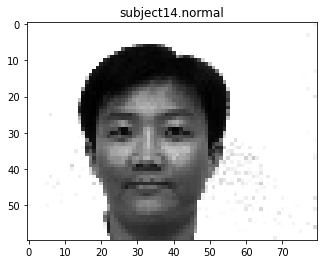

In [12]:
H,W = 60,80
def load_img(img_path):
    img = image.img_to_array(image.load_img(img_path,target_size = [H,W])).astype('uint8')
    return img

def img2gray(img):
    return img.mean(axis=-1)

rand_file = np.random.choice(files)
img = img2gray(load_img(rand_file)) / 255
print(img.shape)
plt.imshow(img,cmap = 'gray')
plt.title(rand_file.split('/')[-1])
plt.show()

In [13]:
## load all images
imgs_shape = (N,H,W)
images_arr = np.zeros(imgs_shape)
for i,file in enumerate(files):
    img = load_img(file)
    img = img2gray(img)/255.0
    images_arr[i] = img

print(images_arr.shape,images_arr.max(),images_arr.min())

(166, 60, 80) 1.0 0.0


In [14]:
# rand_img = images_arr[np.random.randint(0,N),:,:]
# print(rand_img.shape)
# plt.imshow(rand_img,cmap = 'gray')

In [15]:
# print(np.all(img[:,:,0] == img[:,:,1]),np.all(img[:,:,0] == img[:,:,2]))

In [16]:
labels = np.zeros(N)
for i,f in enumerate(files):
    f_name = f.split('/')[-1]
    subject_name = f_name.split('.')[0]
    
    label = int(subject_name.replace('subject','')) - 1
    labels[i] = label
    
print(labels.shape)

(166,)


In [17]:
label_count = Counter(labels)
label_count

Counter({13.0: 11,
         1.0: 11,
         3.0: 11,
         11.0: 11,
         8.0: 11,
         0.0: 12,
         6.0: 11,
         12.0: 11,
         7.0: 11,
         14.0: 11,
         9.0: 11,
         2.0: 11,
         4.0: 11,
         5.0: 11,
         10.0: 11})

In [18]:
uniq_labels = set(label_count.keys())
n_subjects = len(uniq_labels)

In [19]:
# test set consists of 3 images of each subject
n_test = 3 * n_subjects
n_train = N - n_test
# print(n_test,n_train)

In [20]:
train_images = np.zeros((n_train,H,W))
train_labels = np.zeros(n_train)
test_images = np.zeros((n_test,H,W))
test_labels = np.zeros(n_test)

In [21]:
count_so_far = {}
test_count = 0
train_count = 0
for i,label in enumerate(labels):
    if label not in count_so_far:
        count_so_far[label] = 0
    
    count_so_far[label] += 1
    if count_so_far[label] <= 3:
        test_images[test_count] = images_arr[i]
        test_labels[test_count] = label
        test_count += 1
        
    else:
        train_images[train_count] = images_arr[i]
        train_labels[train_count] = label
        train_count += 1
        
print(train_images.shape,train_images.max(),train_labels.shape)
print(test_images.shape,test_images.max(),test_labels.shape)

(121, 60, 80) 1.0 (121,)
(45, 60, 80) 1.0 (45,)


In [22]:
# creating label - index mapping 
train_label2idx = {} # maps label to list of indices for train data
test_label2idx = {} # maps label to list of indices for test data

for idx,label in enumerate(train_labels):
    if label not in train_label2idx:
        train_label2idx[label] = [idx]
    else:
        train_label2idx[label].append(idx)
        
for idx,label in enumerate(test_labels):
    if label not in test_label2idx:
        test_label2idx[label] = [idx]
    else:
        test_label2idx[label].append(idx)

In [23]:
# create sample training dataset
train_positives = []
train_negatives = []
test_positives = []
test_negatives = []

for label,indices in train_label2idx.items():
    # get set of negative images
    other_indices = set(range(n_train)) - set(indices)
    for i,idx1 in enumerate(indices):
        # create tuples for positivees
        for idx2 in indices[i+1:]:
            train_positives.append((idx1,idx2))
        # create tuples for neagtives
        for idx2 in other_indices:
            train_negatives.append((idx1,idx2))
            
for label,indices in test_label2idx.items():
    other_indices = set(range(n_test)) - set(indices)
    for i,idx1 in enumerate(indices):
        for idx2 in indices[i+1:]:
            test_positives.append((idx1,idx2))
    
        for idx2 in other_indices:
            test_negatives.append((idx1,idx2))
            
print(len(train_positives),len(train_negatives))
print(len(test_positives),len(test_negatives))

428 13664
45 1890


In [25]:
def train_generator(batch_size = 32):
    n_batches = int(np.ceil(len(train_positives) / batch_size))
    
    while True:
        np.random.shuffle(train_positives)
        n_samples = batch_size * 2
        shape = (n_samples,H,W)
        x_batch_1 = np.zeros(shape)
        x_batch_2 = np.zeros(shape)
        y_batch = np.zeros(n_samples)
        
        for i in range(n_batches):
            pos_batch_indices=train_positives[i*batch_size:(i+1)*batch_size]
            # filling up x batch and y batch
            j=0
            for idx1,idx2 in pos_batch_indices:
                x_batch_1[j] = train_images[idx1]
                x_batch_2[j] = train_images[idx2]
                y_batch[j] = 1 # counting matches
                j += 1
                
            neg_indices = np.random.choice(len(train_negatives),size=len(pos_batch_indices),replace = False)
            for neg in neg_indices:
                idx1,idx2 = train_negatives[neg]
                x_batch_1[j] = train_images[idx1]
                x_batch_2[j] = train_images[idx2]
                y_batch[j] = 0 # counting negatives
                j += 1 
                
            x1 = x_batch_1[:j]
            x2 = x_batch_2[:j]
            y = y_batch[:j]
            
            # reshape
            x1 = x1.reshape(-1,1,H,W)
            x2 = x2.reshape(-1,1,H,W)
            
            # convert to torch tensors
            x1 = torch.from_numpy(x1).float()
            x2 = torch.from_numpy(x2).float()
            y = torch.from_numpy(y).float()
            
            yield [x1,x2],y

In [33]:
def test_generator(batch_size = 16):
    n_batches = int(np.ceil(len(test_positives)/batch_size))
    while True:
        np.random.shuffle(test_positives)
        n_samples = batch_size *2
        x_batch_1 = np.zeros((n_samples,H,W))
        x_batch_2 = np.zeros((n_samples,H,W))
        y_batch = np.zeros(n_samples)
        
        for i in range(n_batches):
            
            j = 0 
            pos_batch = test_positives[i*batch_size : (i+1)*batch_size]
            for idx1,idx2 in pos_batch:
                x_batch_1[j] = test_images[idx1]
                x_batch_2[j] = test_images[idx2]
                y_batch[j] = 1
                j += 1
                
            neg_batch = np.random.choice(len(test_negatives),size = len(pos_batch),replace = False)
            for neg in neg_batch:
                idx1,idx2 = test_negatives[neg]
                x_batch_1[j] = test_images[idx1]
                x_batch_2[j] = test_images[idx2]
                y_batch[j] = 0 
                j += 1
                
            x1 = x_batch_1[:j].reshape(-1,1,H,W)
            x2 = x_batch_2[:j].reshape(-1,1,H,W)
            y = y_batch[:j]
            
            x1 = torch.from_numpy(x1).float()
            x2 = torch.from_numpy(x2).float()
            y = torch.from_numpy(y).float()
            
            yield [x1,x2],y

In [42]:
# building the model
class SiameseNN(nn.Module):
    def __init__(self,output_dim):
        super(SiameseNN,self).__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(1,32,kernel_size = 3), # H = (60 - 3 + 0)/1 + 1 , W = (80 - 3 + 0)/1 + 1
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2), # H = 58 / 2 , W = 78 / 2
            nn.Conv2d(32,64,kernel_size = 3), # H = 27 , W = 37
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2), # H = 27 // 2 , W = 37 // 2
            nn.Flatten(),
            nn.Linear(13 * 18 * 64,128),
            nn.ReLU(),
            nn.Linear(128,output_dim)
        )
        
    def forward(self,x1,x2):
        feats1 = self.cnn(x1)
        feats2 = self.cnn(x2)
        
        return torch.norm(feats1 - feats2,dim=-1)

In [45]:
model = SiameseNN(50)
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
model.to(DEVICE)

cuda:0


SiameseNN(
  (cnn): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten()
    (9): Linear(in_features=14976, out_features=128, bias=True)
    (10): ReLU()
    (11): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [48]:
def contrast_loss(pred,target):
    # contrastive loss function
    nonmatch = F.relu(1 - pred)
    return torch.mean(target*pred**2 + (1-target)*nonmatch**2)

optimizer = torch.optim.Adam(model.parameters(),0.001)

In [49]:
def train_batch_gd(model,optimizer,criterion,train_gen,test_gen,train_steps,test_steps,epochs,device):
    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    
    for epoch in range(epochs):
        model.train()
        start_time = time.time()
        train_loss = []
        steps = 0
        for [x1,x2],target in train_gen:
            x1,x2,target = x1.to(device),x2.to(device),target.to(device)
            
            optimizer.zero_grad()
            out = model(x1,x2)
            loss = criterion(out,target)
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            steps += 1
             
            if steps >= train_steps:
                break
            
        train_l = np.mean(train_loss)
        train_losses[epoch] = train_l
        
        model.eval()
        test_loss = []
        steps = 0
        for [x1,x2],target in test_gen:
            x1,x2,target = x1.to(device),x2.to(device),target.to(device)
            
            out = model(x1,x2)
            loss = criterion(out,target)
            test_loss.append(loss.item())
            
            steps += 1
            if steps >= test_steps:
                break
        test_l = np.mean(test_loss)
        test_losses[epoch] = test_l
        
        time_taken = time.time() - start_time
        
        print(f'Epoch : {epoch}, train_loss : {train_l:.4f}, test_loss : {test_l:.4f}, time : {time_taken}')
    return train_losses,test_losses

In [51]:
train_batch_size = 32
test_batch_size = 8
n_train_batches = int(np.ceil(len(train_positives) / train_batch_size))
n_test_batches = int(np.ceil(len(test_positives)/test_batch_size))
train_gen = train_generator(train_batch_size)
test_gen = test_generator(test_batch_size)
n_epochs = 100

train_loss,test_loss = train_batch_gd(model,optimizer,contrast_loss,train_gen,test_gen,n_train_batches,n_test_batches,n_epochs,DEVICE)

Epoch : 0, train_loss : 0.8246, test_loss : 0.2094, time : 1.4156641960144043
Epoch : 1, train_loss : 0.2458, test_loss : 0.1702, time : 0.4763758182525635
Epoch : 2, train_loss : 0.1098, test_loss : 0.1760, time : 0.4162178039550781
Epoch : 3, train_loss : 0.0560, test_loss : 0.1097, time : 0.42357468605041504
Epoch : 4, train_loss : 0.0365, test_loss : 0.1209, time : 0.41790056228637695
Epoch : 5, train_loss : 0.0366, test_loss : 0.1130, time : 0.41670703887939453
Epoch : 6, train_loss : 0.0237, test_loss : 0.1140, time : 0.41388678550720215
Epoch : 7, train_loss : 0.0160, test_loss : 0.1092, time : 0.4165325164794922
Epoch : 8, train_loss : 0.0110, test_loss : 0.1048, time : 0.41327571868896484
Epoch : 9, train_loss : 0.0131, test_loss : 0.1095, time : 0.41313648223876953
Epoch : 10, train_loss : 0.0203, test_loss : 0.0943, time : 0.4137258529663086
Epoch : 11, train_loss : 0.0152, test_loss : 0.1119, time : 0.41311025619506836
Epoch : 12, train_loss : 0.0101, test_loss : 0.1149, ti

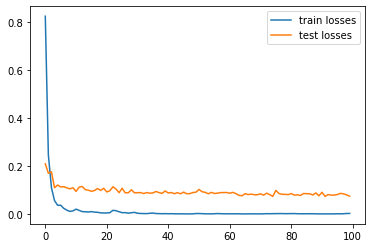

In [52]:
plt.plot(train_loss,label = 'train losses')
plt.plot(test_loss,label = 'test losses')
plt.legend()
plt.show()

In [53]:
def predict(x1,x2):
    x1 = torch.from_numpy(x1).float().to(DEVICE)
    x2 = torch.from_numpy(x2).float().to(DEVICE)
    with torch.no_grad():
        dist = model(x1,x2).cpu().numpy()
        return dist.flatten()


def get_train_accuracy(threshold = 0.85):
    positive_distances = []
    negative_distances = []
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    batch_size = 32
    x_batch_1 = np.zeros((batch_size,1,H,W))
    x_batch_2 = np.zeros((batch_size,1,H,W))
    n_batches = int(np.ceil(len(train_positives) / batch_size))
    
    for i in range(n_batches):
        print(f'pos batch : {i + 1}/{n_batches}')
        pos_batch = train_positives[i*batch_size : (i+1)*batch_size]
        j = 0
        for idx1,idx2 in pos_batch:
            x_batch_1[j,0] = train_images[idx1]
            x_batch_2[j,0] = train_images[idx2]
            j += 1
            
        x1 = x_batch_1[:j]
        x2 = x_batch_2[:j]
        distances = predict(x1,x2)
        positive_distances += distances.tolist()
        
        tp += (distances < threshold).sum()
        fn += (distances > threshold).sum()
        
    n_batches = int(np.ceil(len(train_negatives) / batch_size))
    for i in range(n_batches):
        print(f'neg batch : {i + 1}/{n_batches}')
        neg_batch = train_negatives[i*batch_size : (i+1)*batch_size]
        
        j = 0
        for idx1,idx2 in neg_batch:
            x_batch_1[j,0] = train_images[idx1]
            x_batch_2[j,0] = train_images[idx2]
            j += 1
        
        x1 = x_batch_1[:j]
        x2 = x_batch_2[:j]
        distances = predict(x1,x2)
        negative_distances += distances.tolist()
        
        fp += (distances < threshold).sum()
        tn += (distances > threshold).sum()
        
    tpr = tp/(tp + fn)
    tnr = tn/(tn + fp)
    print(f'sensitivity(tpr) : {tpr}, specificity(tnr) : {tnr}')
    
    plt.hist(negative_distances,bins = 20,density=True,label='negative distances')
    plt.hist(positive_distances,bins = 20,density=True,label='positive distances')
    plt.legend()
    plt.show()
    

 pos batch : 1/14
 pos batch : 2/14
 pos batch : 3/14
 pos batch : 4/14
 pos batch : 5/14
 pos batch : 6/14
 pos batch : 7/14
 pos batch : 8/14
 pos batch : 9/14
 pos batch : 10/14
 pos batch : 11/14
 pos batch : 12/14
 pos batch : 13/14
 pos batch : 14/14
neg batch : 1/427
neg batch : 2/427
neg batch : 3/427
neg batch : 4/427
neg batch : 5/427
neg batch : 6/427
neg batch : 7/427
neg batch : 8/427
neg batch : 9/427
neg batch : 10/427
neg batch : 11/427
neg batch : 12/427
neg batch : 13/427
neg batch : 14/427
neg batch : 15/427
neg batch : 16/427
neg batch : 17/427
neg batch : 18/427
neg batch : 19/427
neg batch : 20/427
neg batch : 21/427
neg batch : 22/427
neg batch : 23/427
neg batch : 24/427
neg batch : 25/427
neg batch : 26/427
neg batch : 27/427
neg batch : 28/427
neg batch : 29/427
neg batch : 30/427
neg batch : 31/427
neg batch : 32/427
neg batch : 33/427
neg batch : 34/427
neg batch : 35/427
neg batch : 36/427
neg batch : 37/427
neg batch : 38/427
neg batch : 39/427
neg batch :

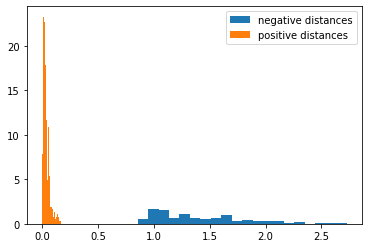

In [54]:
get_train_accuracy(0.65)

In [55]:
def get_test_accuracy(threshold = 0.85):
    positive_distances = []
    negative_distances = []
    
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    batch_size = 32
    x_batch_1 = np.zeros((batch_size,1,H,W))
    x_batch_2 = np.zeros((batch_size,1,H,W))
    n_batches = int(np.ceil(len(test_positives) / batch_size))
    
    for i in range(n_batches):
        print(f'pos batch : {i + 1}/{n_batches}')
        pos_batch = test_positives[i*batch_size : (i+1)*batch_size]
        j = 0
        for idx1,idx2 in pos_batch:
            x_batch_1[j,0] = test_images[idx1]
            x_batch_2[j,0] = test_images[idx2]
            j += 1
            
        x1 = x_batch_1[:j]
        x2 = x_batch_2[:j]
        distances = predict(x1,x2)
        positive_distances += distances.tolist()
        
        tp += (distances < threshold).sum()
        fn += (distances > threshold).sum()
        
    n_batches = int(np.ceil(len(test_negatives) / batch_size))
    for i in range(n_batches):
        print(f'neg batch : {i + 1}/{n_batches}')
        neg_batch = test_negatives[i*batch_size : (i+1)*batch_size]
        
        j = 0
        for idx1,idx2 in neg_batch:
            x_batch_1[j,0] = test_images[idx1]
            x_batch_2[j,0] = test_images[idx2]
            j += 1
        
        x1 = x_batch_1[:j]
        x2 = x_batch_2[:j]
        distances = predict(x1,x2)
        negative_distances += distances.tolist()
        
        fp += (distances < threshold).sum()
        tn += (distances > threshold).sum()
        
    tpr = tp/(tp + fn)
    tnr = tn/(tn + fp)
    print(f'sensitivity(tpr) : {tpr}, specificity(tnr) : {tnr}')
    
    plt.hist(negative_distances,bins = 20,density=True,label='negative distances')
    plt.hist(positive_distances,bins = 20,density=True,label='positive distances')
    plt.legend()
    plt.show()

pos batch : 1/2
pos batch : 2/2
neg batch : 1/60
neg batch : 2/60
neg batch : 3/60
neg batch : 4/60
neg batch : 5/60
neg batch : 6/60
neg batch : 7/60
neg batch : 8/60
neg batch : 9/60
neg batch : 10/60
neg batch : 11/60
neg batch : 12/60
neg batch : 13/60
neg batch : 14/60
neg batch : 15/60
neg batch : 16/60
neg batch : 17/60
neg batch : 18/60
neg batch : 19/60
neg batch : 20/60
neg batch : 21/60
neg batch : 22/60
neg batch : 23/60
neg batch : 24/60
neg batch : 25/60
neg batch : 26/60
neg batch : 27/60
neg batch : 28/60
neg batch : 29/60
neg batch : 30/60
neg batch : 31/60
neg batch : 32/60
neg batch : 33/60
neg batch : 34/60
neg batch : 35/60
neg batch : 36/60
neg batch : 37/60
neg batch : 38/60
neg batch : 39/60
neg batch : 40/60
neg batch : 41/60
neg batch : 42/60
neg batch : 43/60
neg batch : 44/60
neg batch : 45/60
neg batch : 46/60
neg batch : 47/60
neg batch : 48/60
neg batch : 49/60
neg batch : 50/60
neg batch : 51/60
neg batch : 52/60
neg batch : 53/60
neg batch : 54/60
neg b

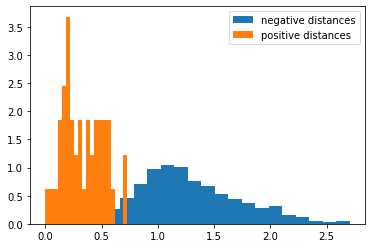

In [56]:
get_test_accuracy(0.6)